<a href="https://colab.research.google.com/github/srikrishnasajjarao/snooker_ball_tracking/blob/main/grounded_sam_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Grounded SAM Inpainting Demo](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

## Why this project?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment everything** with text inputs!



## Install

In [1]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1807, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1807 (delta 9), reused 1 (delta 1), pack-reused 1789 (from 2)
Receiving objects: 100% (1807/1807), 155.84 MiB | 44.64 MiB/s, done.
Resolving deltas: 100% (830/830), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
!pip uninstall -y supervision
!pip install -q supervision==0.4.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1
0.4.0


## Imports

In [3]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Load models

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Grounding DINO model

In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [6]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

<ipython-input-5-289f8e45116f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cache_file, map_location=device)


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [7]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2025-01-13 04:33:52--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  45.2MB/s    in 17s     

2025-01-13 04:34:09 (141 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Inference

Image downloaded from url: https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png and saved to: assets/inpaint_demo.jpg.


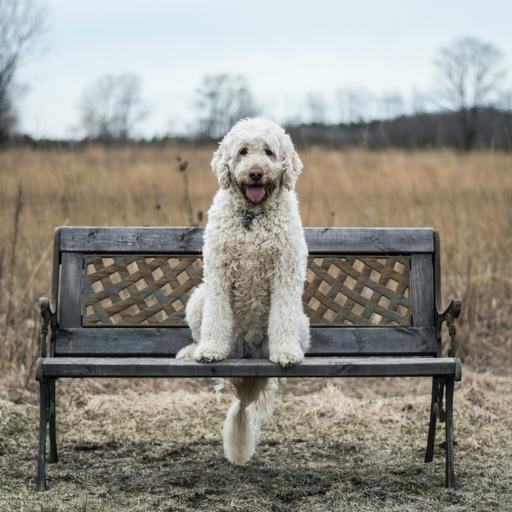

In [8]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo.jpg"
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [9]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

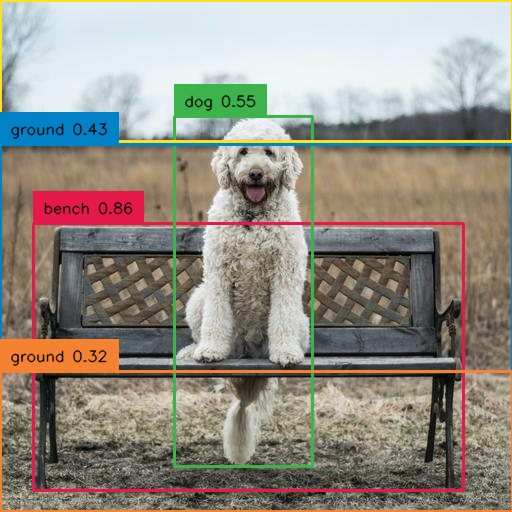

In [17]:
annotated_frame, detected_boxes = detect(image, text_prompt="bench.dog.sky.ground", model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM for segmentation

In [18]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

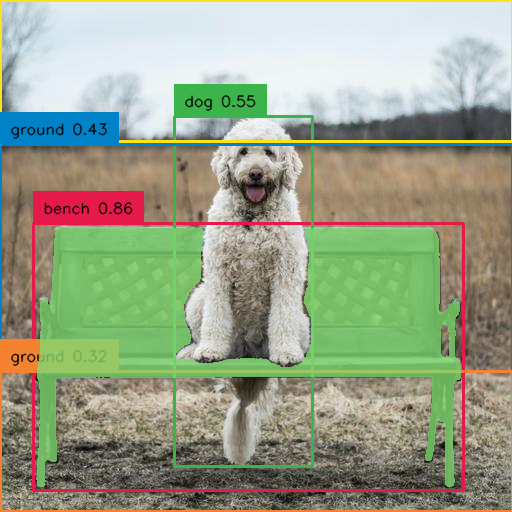

In [19]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)